# Sentiment analysis for Twitter Text
- Primary step of the Morality based sentimental analysis. Text is tockenized using TF-IDF vectorization and BERT

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score,precision_recall_fscore_support
from sklearn.model_selection import train_test_split,KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import torch.optim as optim
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments,BertPreTrainedModel, BertConfig,BertModel, AutoTokenizer,get_scheduler,AdamW
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import requests
import os
import zipfile

In [ ]:
# Load dataset from CSV file
file_path = "/content/updated_data.csv"  # Replace with the actual file path
df = pd.read_csv(file_path, encoding = "ISO-8859-1")

# Display the first few rows of the dataset
print(df.head())

  Corpus                                         Tweet Text  Stance  \
0    EVM  #EVMs are easy to manipulate . This was demons...      -1   
1    CAA             Congratulations\nCAA  is arrived  #CAA       1   
2    CAA  My dear Indian muslims we are 35 crores of pop...      -1   
3    CAA  This guy was part of anti Hindu protests in th...       0   
4    CAA  Woman protester breaks down while speaking to ...       0   

  Foundation  cleaned_tweet  
0   fairness            NaN  
1    loyalty            NaN  
2    loyalty            NaN  
3   fairness            NaN  
4       care            NaN  


In [ ]:
# Find the number of rows for each unique value in the first column
class_counts = df.iloc[:, 0].value_counts()

# Print the counts for each class
print("Number of rows for each class:")
print(class_counts)

# Print the total number of rows
total_rows = df.shape[0]
print("\nTotal number of rows:", total_rows)

Number of rows for each class:
Corpus
CAA                     206
UCC                     190
EVM                     178
Animal Sacrifices       166
Anti Conversion Laws    162
LGBTQ                   153
Brain Drain             147
Name: count, dtype: int64

Total number of rows: 1202


In [ ]:
# Preprocess the data
X = df['Tweet Text']
y = df['Stance']+1

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Bert Model
- The data set is limited(1213 Tweets).
- Model is designed with bert as encoder and fully connected layers as classifier
- Performing K(5 here) fold cross validation for analyzing the performance of the model on the dataset.

In [ ]:
# Model Setup
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
class BertForSentimentAnalysis(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(0.3)  # Reduce dropout

        # self.fc1 = nn.Linear(config.hidden_size, 512)  # One small FC layer
        # self.relu = nn.ReLU()
        self.classifier = nn.Linear(config.hidden_size, 3)  # Output layer

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output  # [CLS] token representation

        x = self.dropout(pooled_output)
        # x = self.fc1(x)
        # x = self.relu(x)

        logits = self.classifier(x)  # Final predictions

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        return {"loss": loss, "logits": logits}


In [ ]:
def k_fold_cross_validation(model, dataset, texts, k=5, batch_size=8, epochs=3, lr=2e-5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    losses, accuracies, precisions, recalls, f1_scores = [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n🔹 Fold {fold+1}/{k}")

        # Create data samplers
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        # Define training arguments
        training_args = TrainingArguments(
            output_dir=f"./results/fold{fold}",
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            evaluation_strategy="epoch",
            save_strategy="no",
            learning_rate=lr,
            weight_decay=0.01,
            logging_dir="./logs",
            logging_steps=10
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=dataset,
            eval_dataset=dataset,  # Full dataset, but using samplers
        )

        # Train & Evaluate
        trainer.train()
        eval_result = trainer.evaluate()
        losses.append(eval_result["eval_loss"])

        # Store predictions & labels
        all_preds, all_labels, misclassified_samples = [], [], []

        model.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_loader):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs["logits"]
                preds = torch.argmax(logits, dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Store misclassified samples
                for i, (pred, true) in enumerate(zip(preds, labels)):
                    if pred != true:
                        misclassified_samples.append((texts[val_idx[batch_idx * batch_size + i]], true.item(), pred.item()))

        # Compute Metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=0)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f"✅ Fold {fold+1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"🔹 Misclassifications per Class (Actual → Predicted):\n{cm - np.diag(np.diag(cm))}")

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - Fold {fold+1}")
        plt.show()

        # Print some misclassified tweets
        print("\n🚨 Misclassified Tweets:")
        for text, true, pred in misclassified_samples[:5]:  # Show first 5 misclassified examples
            print(f"❌ Tweet: \"{text}\" | True: {true} | Predicted: {pred}")

    # Print Final Averages
    print(f"\n🎯 Final Results Across {k} Folds:")
    print(f"Avg Loss: {np.mean(losses):.4f}")
    print(f"Avg Accuracy: {np.mean(accuracies):.4f}")
    print(f"Avg Precision: {np.mean(precisions):.4f}")
    print(f"Avg Recall: {np.mean(recalls):.4f}")
    print(f"Avg F1-Score: {np.mean(f1_scores):.4f}")



In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 128
bert_train_dataset = CustomDataset(X_train.tolist(), y_train.tolist(), bert_tokenizer, MAX_LEN)
bert_test_dataset = CustomDataset(X_test.tolist(), y_test.tolist(), bert_tokenizer, MAX_LEN)

In [ ]:
bert_labels, bert_preds = [],[]
def evaluate_on_test(model, test_dataset, batch_size=8):
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Store predictions & true labels

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs["logits"]
            preds = torch.argmax(logits, dim=1)

            bert_preds.extend(preds.cpu().numpy())
            bert_labels.extend(labels.cpu().numpy())



In [ ]:
config = BertConfig.from_pretrained("bert-base-uncased", num_labels=3)
model = BertForSentimentAnalysis.from_pretrained("bert-base-uncased", config=config)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSentimentAnalysis were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSentimentAnalysis(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [ ]:
text = df["Tweet Text"].tolist()


🔹 Fold 1/5


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nlvmadhavca3 (nlvmadhavca3-vasavi-college-of-engineering) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.981100,0.739966
2,0.658600,0.408954
3,0.409800,0.299400


✅ Fold 1 - Accuracy: 0.8994, Precision: 0.8986, Recall: 0.8994, F1-score: 0.8989
🔹 Misclassifications per Class (Actual → Predicted):
[[0 3 6]
 [1 0 1]
 [6 0 0]]


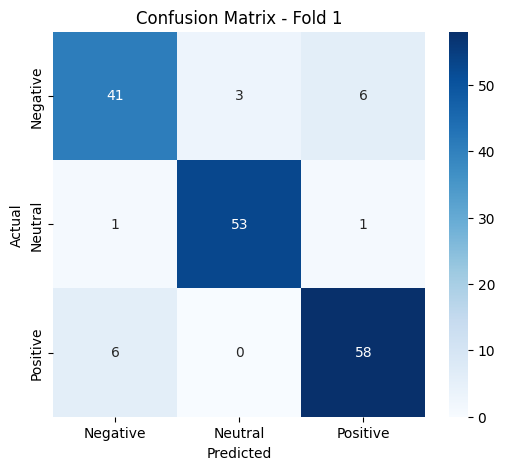


🚨 Misclassified Tweets:
❌ Tweet: "My dear Indian muslims we are 35 crores of population in india if we get united each & every politician & hindutvawadis will become useless

Remember the #caa protests" | True: 2 | Predicted: 0
❌ Tweet: "The #EVM scam !Why should it be treated as a holy black box ? We need openness and transparency" | True: 0 | Predicted: 2
❌ Tweet: "In my POV, If BJP could really manipulate  #EVM, they would have never let go #Karnataka and definitely took #Bengal  Agree?" | True: 0 | Predicted: 1
❌ Tweet: "Every religion has its own rituals, and animal sacrifice is part of some. However, we must ensure that these practices are carried out with respect for both the faith and the creatures involved" | True: 1 | Predicted: 2
❌ Tweet: "Animal sacrifice is the worst way of showing our respect to God." | True: 0 | Predicted: 2

🔹 Fold 2/5


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.233900,0.128873
2,0.190100,0.061044
3,0.085100,0.040013


✅ Fold 2 - Accuracy: 0.9881, Precision: 0.9881, Recall: 0.9881, F1-score: 0.9881
🔹 Misclassifications per Class (Actual → Predicted):
[[0 1 0]
 [1 0 0]
 [0 0 0]]


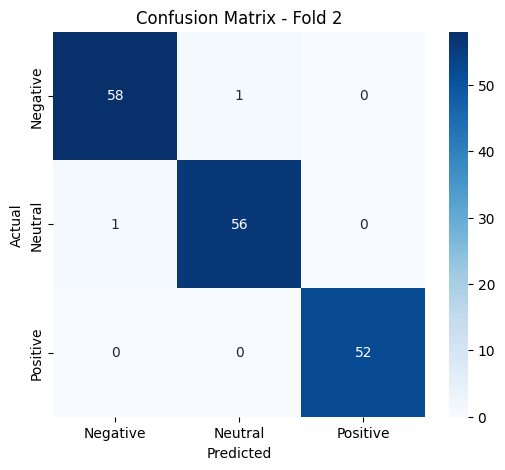


🚨 Misclassified Tweets:
❌ Tweet: "Gender Identity Disorder was first set as a diagnosis in the Diagnostic Statistical Manual (used to diagnosis mental illnesses) in 1987. It was changed to Gender Dysphoria in 2013 to erase the stigma attached to the word Disorder. Note the prevalence rate. I wonder if some of those interesting studies have lapsed due to not wanting to find the biological, genetic, or psychological influences that may be causal and perhaps able to be addressed. Note the paragraph that advises the proper course of treatment to make sure the person is doing it for the right reason! And how much higher the success rate was. " | True: 1 | Predicted: 0
❌ Tweet: "Brain drain isn't just about money; it's about dreams, growth, and recognition. Invest in people, and they'll invest back. #TalentDevelopment" | True: 0 | Predicted: 1

🔹 Fold 3/5


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.091700,0.069208
2,0.101900,0.007056
3,0.008100,0.002964


✅ Fold 3 - Accuracy: 0.9940, Precision: 0.9942, Recall: 0.9940, F1-score: 0.9941
🔹 Misclassifications per Class (Actual → Predicted):
[[0 0 0]
 [0 0 0]
 [0 1 0]]


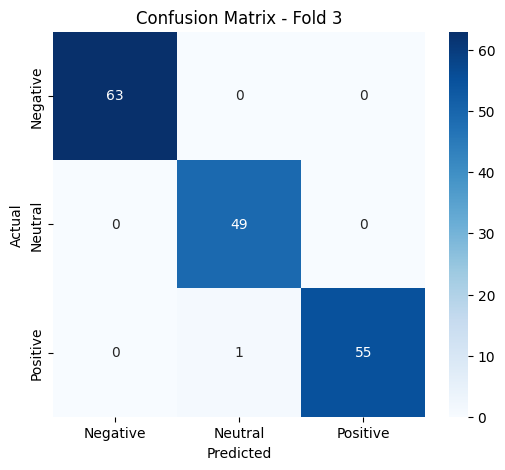


🚨 Misclassified Tweets:
❌ Tweet: "Building Opportunities in India

#braindrain #IndiaYouth #StayOrGo #BuildIndia #StudyAbroad #IndiaJobs #YouthMigration #SupportLocal #OpportunityIndia #IndiaFuture" | True: 2 | Predicted: 1

🔹 Fold 4/5


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.006900,0.042104
2,0.087200,0.004925
3,0.060000,0.011673


✅ Fold 4 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
🔹 Misclassifications per Class (Actual → Predicted):
[[0 0 0]
 [0 0 0]
 [0 0 0]]


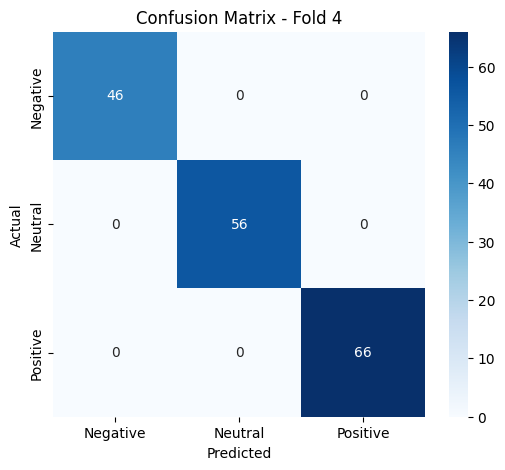


🚨 Misclassified Tweets:

🔹 Fold 5/5


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.000400,0.039976
2,0.000100,0.000034
3,0.000000,0.000034


✅ Fold 5 - Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
🔹 Misclassifications per Class (Actual → Predicted):
[[0 0 0]
 [0 0 0]
 [0 0 0]]


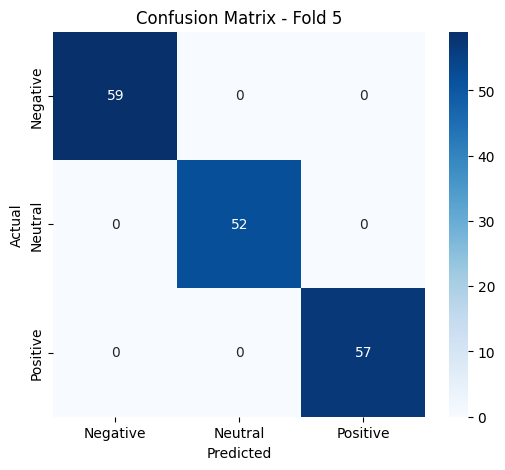


🚨 Misclassified Tweets:

🎯 Final Results Across 5 Folds:
Avg Loss: 0.0708
Avg Accuracy: 0.9763
Avg Precision: 0.9762
Avg Recall: 0.9763
Avg F1-Score: 0.9762


In [ ]:
# Perform K-Fold Cross-Validation on training data
k_fold_cross_validation(model, bert_train_dataset, k=5, batch_size=8, epochs=3, lr=2e-5, texts = text)

In [ ]:
evaluate_on_test(model, bert_test_dataset, batch_size=8)

# Tfidf with lstm
- The data set is limited(1207 Tweets).
- Data encoded using TF-IDF vectorizer and fed to lstm for classification
- Performing K(5 here) fold cross validation for analyzing the model

In [101]:
class SentimentDataset(Dataset):
    def __init__(self, sequences, labels, vectorizer):
        self.sequences = vectorizer.transform(sequences).toarray()  # Transform text to numerical features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'features': torch.tensor(self.sequences[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [157]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.hidden1 = nn.Linear(hidden_dim, 128)
        self.hidden2 = nn.Linear(128, 64)
        self.hidden3 = nn.Linear(64, 32)
        self.classifier = nn.Linear(32, output_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
      # Reshape input to (batch_size, sequence_length=1, input_size)
      x = x.unsqueeze(1)
      _, (hidden, _) = self.lstm(x)
      output = self.dropout(hidden[-1])
      output = self.hidden1(output)
      output = self.dropout(output)
      output = self.hidden2(output)
      output = self.dropout(output)
      output = self.hidden3(output)
      output = self.dropout(output)
      return self.classifier(output)

In [161]:
def k_fold_cross_validation(model, dataset, texts, labels, k=5, batch_size=8, epochs=5, lr=2e-5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

    accuracies, precisions, recalls, f1_scores = [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f"\n🔹 Fold {fold+1}/{k}")

        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        for epoch in range(epochs):
            model.train()
            for batch in train_loader:
                optimizer.zero_grad()

                features = batch['features'].to(device)
                labels = batch['label'].to(device)

                outputs = model(features)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

            scheduler.step()

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                outputs = model(features)
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch['label'].cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted", zero_division=0)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        print(f"✅ Fold {fold+1} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix for Fold {fold+1}')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    print(f"\n🎯 Final Results Across {k} Folds:")
    print(f"Avg Accuracy: {np.mean(accuracies):.4f}")
    print(f"Avg Precision: {np.mean(precisions):.4f}")
    print(f"Avg Recall: {np.mean(recalls):.4f}")
    print(f"Avg F1-Score: {np.mean(f1_scores):.4f}")


In [130]:
vectorizer = TfidfVectorizer(max_features=512)
features = vectorizer.fit_transform(X).toarray()
vocab = vectorizer.get_feature_names_out()

In [142]:
input_dim = features.shape[1]
hidden_dim = 256
output_dim = 3

In [149]:
print(input_dim)

512


In [150]:
dataset = SentimentDataset(X, y, vectorizer)

In [158]:
model = LSTMClassifier(input_dim, hidden_dim, output_dim)


In [159]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMClassifier(
  (lstm): LSTM(512, 256, batch_first=True)
  (hidden1): Linear(in_features=256, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (hidden3): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


🔹 Fold 1/5
✅ Fold 1 - Accuracy: 0.3112, Precision: 0.0968, Recall: 0.3112, F1-score: 0.1477


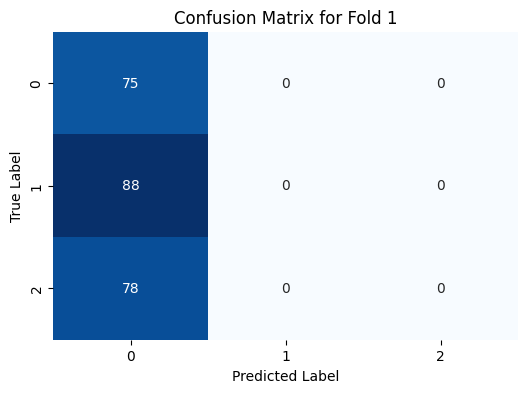


🔹 Fold 2/5
✅ Fold 2 - Accuracy: 0.3237, Precision: 0.1048, Recall: 0.3237, F1-score: 0.1583


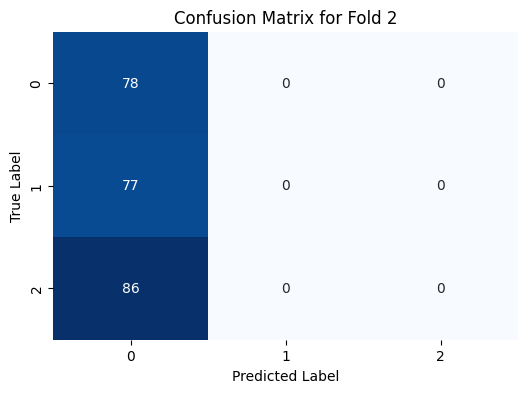


🔹 Fold 3/5
✅ Fold 3 - Accuracy: 0.3083, Precision: 0.0951, Recall: 0.3083, F1-score: 0.1453


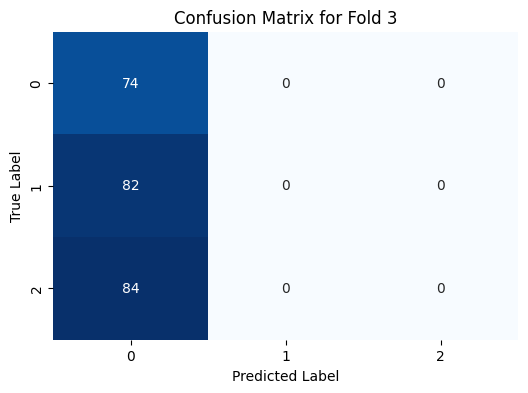


🔹 Fold 4/5
✅ Fold 4 - Accuracy: 0.3583, Precision: 0.1284, Recall: 0.3583, F1-score: 0.1891


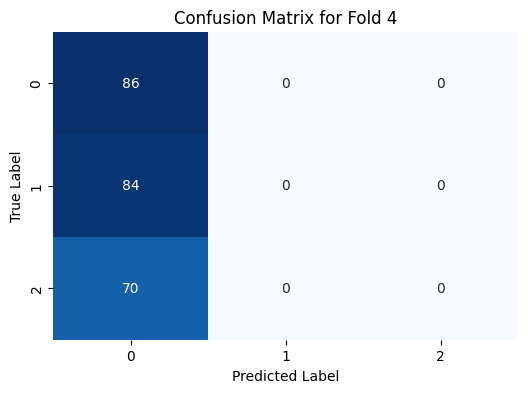


🔹 Fold 5/5
✅ Fold 5 - Accuracy: 0.3042, Precision: 0.0925, Recall: 0.3042, F1-score: 0.1419


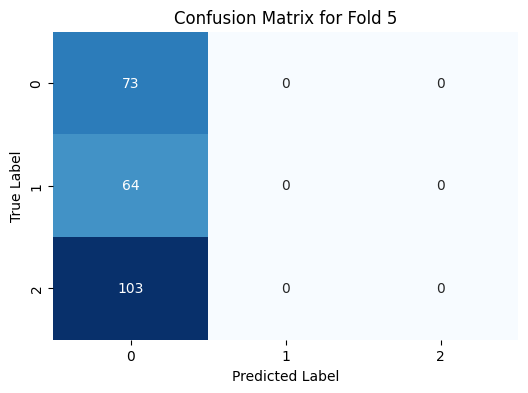


🎯 Final Results Across 5 Folds:
Avg Accuracy: 0.3211
Avg Precision: 0.1035
Avg Recall: 0.3211
Avg F1-Score: 0.1565


In [162]:
k_fold_cross_validation(model, dataset, X, y)